In [26]:
import numpy as np
import time
from numpy import sin, sum, cos, arctan2, pi, real, exp, abs, argmax, sqrt, maximum, concatenate, mean, floor
from numpy.fft import fft, ifft
from numpy.random import randn
from numpy.linalg import eig
from numba import jit, complex128
from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt
from scipy.ndimage.filters import gaussian_filter1d
import collections

## Prueba de funcionamiento para MUSIC en Python + Numba

In [27]:
fs = 48000
np.fft.fftfreq(n=1024*4, d=1/fs)

array([  0.     ,  11.71875,  23.4375 , ..., -35.15625, -23.4375 ,
       -11.71875])

In [28]:
#Direcciones de arribo (conocidas, suponemos que no a futuro)
doas = np.array([-30, 40])
#Distancia entre microfonos en metros
d = 0.21
#Presencia de ruido
noise_w = 0.0
#Signal Size in samples
K = 1024
#Vector de frecuencias
fs = 1024


w = np.fft.fftfreq(n=K, d=1/fs)
#Base frequency for signals
freq = np.array([2, 4])
c = 343 # Speed of sound
fs = K #Sampling frequency same as signal size (1 second)
t = np.arange(1,K+1)/K #Time vector (1 second)

N = 3 #Number of microphones
r = 2 #Number of signals in signal sub-space

#result_freqs = np.zeros(r)

In [29]:
#original signals
s1 = sin(2*pi*freq[0]*t)
s2 = sin(2*pi*freq[1]*t)
s1_f = fft(s1)
s2_f = fft(s2)

#Simulating microphones
x = s1 + s2
theta_m3 = -arctan2(-d/2,-d*sqrt(3)/2)
y = real(ifft(fft(s1)*exp(-1j*2*pi*w*(-d/c)*sin(doas[0]*pi/180)))) + real(ifft(fft(s2)*exp(-1j*2*pi*w*(-d/c)*sin(doas[1]*pi/180))))
z = real(ifft(fft(s1)*exp(-1j*2*pi*w*(-d/c)*cos(theta_m3 - doas[0]*pi/180)))) + real(ifft(fft(s2)*exp(-1j*2*pi*w*(-d/c)*cos(theta_m3 - doas[1]*pi/180))))

#Adding noise
x = x + randn(K)*noise_w/10
y = y + randn(K)*noise_w/10
z = z + randn(K)*noise_w/10

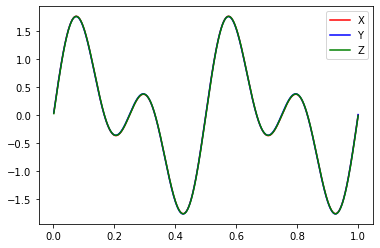

In [30]:
import matplotlib.pyplot as plt


plt.plot(t, x, 'r', label="X") # plotting t, a separately 
plt.plot(t, y, 'b', label="Y") # plotting t, b separately 
plt.plot(t, z, 'g', label="Z") # plotting t, c separately 
plt.legend()
plt.show()

In [31]:
start = time.time()
X = np.vstack([fft(x), fft(y), fft(z)])
end = time.time()
print("Elapsed = %s" % (end - start))

Elapsed = 0.0006985664367675781


In [32]:
#normally, you should do the next step for each appropriate frequency
#we're only doing it in the frequencies that most closely fit s1's and s2's frequency

#Índices de las recuencias fundamentales de las voces a buscar
this_ws = np.array([2, 4])
#this_ws = np.array([85, 95, 105, 115, 125, 135, 145, 155, 165, 175, 185, 195, 205, 215, 225])
r = 2

#MUSIC
num_angles_search = 1800
#Angles to look for orthogonality
angles = np.linspace(-90, 90, num_angles_search)
music_spectrum = np.zeros(num_angles_search)

#Version Numba
@jit(nopython=True)
def MUSIC(X, d, r, w, search_w, num_angles_search, angles, music_spectrum):
    theta_m3 = -arctan2(-d/2, -d*sqrt(3)/2)
    r = 1
    for search_f_idx in this_ws:
        this_X = X[:,search_f_idx].copy().reshape((-1,1))
        #Cov matrix
        R =  this_X @ this_X.T.conj()
        #Eigendecomposition
        D,Q = eig(R)
        #Sorting eigenvalues/vectors
        abs_eig = np.abs(D)
        idx = abs_eig.argsort()[::-1]
        exp_var = abs_eig[idx]/sum(abs_eig)
        found_r = 2
        if exp_var[0] > 0.9:
            found_r = 1
        Q = Q[:,idx]
        #D = D[idx]
        #Getting signal and noise eigenvectors (based on r)
        #Qs = Q[:,:r]
        Qn = Q[:,found_r:].copy()
        #compute steering vectors corresponding to values in angles
        a1 = np.zeros((N,num_angles_search), dtype=np.complex128)
        a1[0,:] = 1 #First mic, no delay
        a1[1,:] = exp(-1j*2*pi*w[search_f_idx]*(-d/c)*sin(angles*pi/180)) #Second mic, delayed one distance
        a1[2,:] = exp(-1j*2*pi*w[search_f_idx]*(-d/c)*cos(theta_m3 - angles*pi/180)) #Third mic, delayed double distance

        #Noise matrix
        Qn_2 = Qn@Qn.T.conj()
        #compute MUSIC spectrum
        r = max(r, found_r)
        for k in range(0, num_angles_search):
            interest = a1[:,k].copy().reshape((1,-1)).transpose()
            music_spectrum[k] = (music_spectrum[k] + abs(1/(interest.conj().T@Qn_2@interest).item()))
    return r

In [33]:
MUSIC(X, d, r, w, this_ws, num_angles_search, angles, music_spectrum)

1

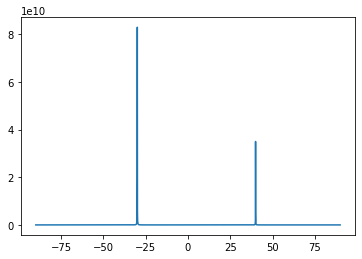

In [34]:
plt.plot(angles, music_spectrum)

## Realizando el benchmark

In [35]:
# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.time()
MUSIC(X, d, r, w, this_ws, num_angles_search, angles, music_spectrum)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

n_reps = 100
iterations = []

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
for i in range(n_reps):
    start = time.time()
    MUSIC(X, d, r, w, this_ws, num_angles_search, angles, music_spectrum)
    end = time.time()
    iterations.append(end - start)
print("Mean elapsed (after compilation) = %s" % np.mean(iterations))
print("STD elapsed (after compilation) = %s" % np.std(iterations))

Elapsed (with compilation) = 0.006069660186767578
Mean elapsed (after compilation) = 0.0027796149253845213
STD elapsed (after compilation) = 0.00022343748284565216


In [36]:
#Extracting results should be transparent
start = time.time()
peak_pos = np.argsort(music_spectrum[find_peaks(gaussian_filter1d(music_spectrum, sigma=10))[0]])[::-1]
out = angles[find_peaks(music_spectrum)[0][peak_pos][:r]]
end = time.time()
print("Elapsed = %s" % (end - start))
out

Elapsed = 0.0006120204925537109


array([-29.96664814,  39.97220678])

In [37]:
def fft_spectrum(s, num_el, eps=1e-7):
    r = (abs(s)/num_el)[:len(s)//2+1]
    r[1:-1] = 2*r[1:-1]
    return r + eps

JACK integration

In [43]:
analyze = []
is_noise = []

In [44]:
import sys
import signal
import os
import jack
import threading
import queue
import subprocess

analyze = []
is_noise = []

res = []
spectrums = []
magnitudes = []
num_hablantes = []

client = jack.Client('DOATracker')

blocksize = client.blocksize
samplerate = client.samplerate
buffersize = 10

qx = queue.Queue(maxsize=blocksize*buffersize)
qy = queue.Queue(maxsize=blocksize*buffersize)
qz = queue.Queue(maxsize=blocksize*buffersize)

timeout = blocksize * buffersize / samplerate

iters = 0

###CHANGE#####
#Direcciones de arribo (conocidas, suponemos que no en lo general)
doas = np.array([60])
d = 0.18
r = 1
##############
#Vector de frecuencias
num_windows_iter = 2
K = blocksize*num_windows_iter
fs = 48000

w = np.fft.fftfreq(n=K, d=1/fs)
#Arreglando indices
w = w[:K//2+1]
w[-1] *= -1

c = 343 # Speed of sound
#fs = K #Sampling frequency same as signal size (1 second)
t = np.arange(1,K+1)/K #Time vector (1 second)

N = 3 #Number of microphones
#MUSIC
num_angles_search = 3601
#Angles to look for orthogonality
angles = np.linspace(-160, 160, num_angles_search)
music_spectrum = np.zeros(num_angles_search)

noise_magnitude = 0
N_LTSE = 6
recent_magnitudes = collections.deque(maxlen=100)
last_n_spectrums = collections.deque(maxlen=N_LTSE)
last_n_LTSE = collections.deque(maxlen=N_LTSE)
reference_noises = collections.deque(maxlen=N_LTSE)
##################END INIT##################

#################Start of JACK Functions##########3
def print_error(*args):
    print(*args, file=sys.stderr)

def xrun(delay):
    print_error("An xrun occured, increase JACK's period size?")

def stop_callback(msg=''):
    if msg:
        print_error(msg)
    event.set()
    raise jack.CallbackExit


if client.status.server_started:
    print('JACK server started')
if client.status.name_not_unique:
    print('unique name {0!r} assigned'.format(client.name))

event = threading.Event()

in1 = client.inports.register('input_1')
in2 = client.inports.register('input_2')
in3 = client.inports.register('input_3')

@client.set_process_callback
def process(frames):
    #TODO: Before, check if voice is active now
    try:
        qx.put_nowait(in1.get_array())
        qy.put_nowait(in2.get_array())
        qz.put_nowait(in3.get_array())
    except (queue.Full):
        print("Full Queue")
        stop_callback()
    #global iters
    #iters += 1

@client.set_shutdown_callback
def shutdown(status, reason):
    print('JACK shutdown!')
    print('status:', status)
    print('reason:', reason)
    event.set()


with client:
    start = time.time()
    subprocess.Popen(["/home/mario/Documents/TSIC/Proy/ReadMicWavs",
                      "DOATracker",
                      "input_",
                      "/home/mario/Documents/TSIC/Proy/corpus48000/clean-1source",
                      "3"])
    try:
        while iters < 47*25: #For now, limit iters
            #Resets
            music_spectrum[:] = 0
            x = concatenate((qx.get(timeout=timeout), qx.get(timeout=timeout)))
            y = concatenate((qy.get(timeout=timeout), qy.get(timeout=timeout)))
            z = concatenate((qz.get(timeout=timeout), qz.get(timeout=timeout)))
            #Filtro pre-énfasis
            x = np.append(x[0], x[1:] - 0.97 * x[:-1])
            y = np.append(y[0], y[1:] - 0.97 * y[:-1])
            z = np.append(z[0], z[1:] - 0.97 * z[:-1])
            xfft = fft(x)
            amp_spectrum = fft_spectrum(xfft, len(x))
            analyze.append(xfft)
            last_n_spectrums.append(amp_spectrum)
            if(iters < 5):
                #Build noise floor so we can detect voice activity
                noise_magnitude = max(sum(abs(x)), noise_magnitude)
                is_noise.append(True)
                reference_noises.append(amp_spectrum)
                if iters >= 5:
                    noise_LTDSN += LTDSN
                    nn_LTDSN += 1
            elif sum(abs(x)) > noise_magnitude*1.2:
                #print("nonnoise")
                yfft = fft(y)
                zfft = fft(z)
                X = np.vstack([xfft, yfft, zfft])
                
                num_max_freqs = 10

                freq_peaks = find_peaks(amp_spectrum)[0]
                peaks_ordered = freq_peaks[np.argsort(amp_spectrum[freq_peaks])[::-1]]
                search_fs = peaks_ordered[:num_max_freqs]

                print(w[search_fs])
                if len(search_fs) > 0:
                    is_noise.append(False)
                    num_hablantes.append(MUSIC(X, d, r, w, search_fs, num_angles_search, angles, music_spectrum))
                    music_peaks = find_peaks(music_spectrum)[0]
                    peak_pos = np.argsort(music_spectrum[music_peaks])[::-1]
                    out = angles[music_peaks[peak_pos][:r]]
                    res.append(-out)
                    spectrums.append(-music_spectrum.copy())
                else:
                    is_noise.append(True)
            else:
                is_noise.append(True)

            magnitudes.append(sum(abs(x)))
            recent_magnitudes.append(sum(abs(x)))
            iters += num_windows_iter
    except (queue.Empty):
        print("Empty Queue")
    end = time.time()


print("Elapsed = %s" % (end - start))

ReadMicWavs: Probing app   : DOATracker
ReadMicWavs: With 3 channels with basename: input_X
ReadMicWavs: Reading from  : /home/mario/Documents/TSIC/Proy/corpus48000/clean-1source
ReadCorpusMulti: Channel 1 -> openning /home/mario/Documents/TSIC/Proy/corpus48000/clean-1source/wav_mic1.wav
ReadCorpusMulti: Channel 2 -> openning /home/mario/Documents/TSIC/Proy/corpus48000/clean-1source/wav_mic2.wav
ReadCorpusMulti: Channel 3 -> openning /home/mario/Documents/TSIC/Proy/corpus48000/clean-1source/wav_mic3.wav
ReadMicWavs: JACK sample rate : 48000.
ReadMicWavs: JACK buffer size : 1024.
ReadMicWavs: registering port out_1 
ReadMicWavs: registering port out_2 
ReadMicWavs: registering port out_3 
ReadMicWavs: Connecting DOATracker inputs to our outputs.
ReadMicWavs: Connecting DOATracker:input_1 inputs to our output ReadMicWavs:out_1
ReadMicWavs: Connecting DOATracker:input_2 inputs to our output ReadMicWavs:out_2
ReadMicWavs: Connecting DOATracker:input_3 inputs to our output ReadMicWavs:out_3

[ 234.375  281.25   140.625  187.5    796.875 3796.875  328.125 3890.625
 7171.875  515.625]
[ 281.25   140.625 1078.125 1125.    1265.625 1031.25  1171.875  984.375
  515.625  609.375]
[ 656.25   609.375  703.125 1359.375 1031.25   140.625 1500.    6703.125
 2625.    1593.75 ]
[ 703.125 1593.75  1500.     187.5   1453.125 1687.5   1031.25  1546.875
 1078.125 1218.75 ]
[5109.375 5156.25  5296.875 4546.875 6000.    6187.5   5578.125 6046.875
 4968.75  6562.5  ]
[7312.5   5718.75  7125.    7078.125 7171.875 5812.5   5671.875 6890.625
 5765.625 5296.875]
[4687.5   7453.125 5953.125 6656.25  6609.375 6046.875 5203.125 5343.75
 6140.625 6515.625]
[1640.625 4640.625 2390.625 4593.75  3703.125 2437.5   7359.375 3656.25
 1828.125 1687.5  ]
[1453.125  187.5   1734.375 1593.75  5625.    1687.5   1500.    6937.5
  562.5   5765.625]
[  46.875 6140.625  187.5   5953.125 7593.75   609.375 6187.5    562.5
 4921.875 7265.625]
[  93.75    46.875 3656.25  3234.375 7218.75  3750.    1734.375 3328.125
 47

[6890.625 7031.25  6843.75  7265.625 6937.5   6984.375 7078.125 7359.375
 7312.5   7125.   ]
[1546.875  796.875 1500.     843.75   703.125  656.25  1359.375 1453.125
 3515.625  984.375]
[ 703.125 1593.75  1546.875  562.5   1640.625 2437.5   3562.5   3421.875
 3656.25  3468.75 ]
[ 421.875 1593.75  1500.    1640.625 3843.75   609.375 2531.25  3890.625
 1453.125  468.75 ]
[ 140.625 3656.25  2531.25  3515.625 1546.875 3375.    3562.5   3703.125
 2578.125 1687.5  ]
[2765.625 2812.5   2718.75  2250.    6046.875 6140.625  328.125 6093.75
 3562.5   3328.125]
[2765.625 2953.125 3515.625 2906.25  2812.5   2390.625 3000.     187.5
 2859.375 6000.   ]
[3000.    3046.875 3093.75  3140.625 3468.75  3515.625 2953.125 3187.5
 6984.375 7031.25 ]
[3234.375 3187.5   3140.625 3093.75   375.    3281.25  3046.875 3328.125
 5671.875  187.5  ]
[7031.25  5765.625 6937.5   3046.875 7125.    5531.25  6984.375 3187.5
 5812.5   3140.625]
[3187.5   3234.375 3281.25  3140.625 3093.75  3046.875 6750.    6375.
 6796.8

[3421.875  609.375 3328.125  234.375 3375.    3281.25   468.75   703.125
 3187.5   1265.625]
[ 703.125  234.375  562.5   3234.375  609.375  656.25   468.75   937.5
  796.875 3328.125]
[ 656.25   703.125 3328.125  562.5   3375.     750.     234.375  796.875
 3281.25   890.625]
[ 656.25   750.     796.875  234.375  562.5    890.625  703.125  421.875
  843.75  3421.875]
[750.    703.125 609.375  93.75  562.5   796.875 234.375 843.75  656.25
 281.25 ]
[  93.75   656.25  4359.375  562.5   4453.125  140.625  843.75  2015.625
 4218.75  1171.875]
[4453.125  750.    4640.625  281.25    93.75   656.25  2015.625  703.125
 4828.125 4171.875]
[4500.    4218.75   281.25  4734.375 6281.25  6609.375 4406.25  6421.875
 6750.    2203.125]
[ 4781.25   7453.125  6093.75  21609.375  6140.625  7078.125  6796.875
  7265.625 11531.25   7546.875]
Elapsed = 25.08605170249939


(array([ 2.,  0.,  1.,  2.,  0.,  1.,  0.,  2.,  1.,  0.,  1.,  0.,  1.,
         2.,  1.,  0.,  1.,  0.,  0.,  1.,  3.,  2.,  2.,  3.,  2.,  1.,
         5., 10.,  6.,  8., 10., 32., 57., 50., 18., 10.,  5.,  8.,  3.,
         1.,  1.,  3.,  1.,  2.,  1.,  1.,  1.,  1.,  0.,  0.,  2.]),
 array([-147.64444444, -141.69586057, -135.74727669, -129.79869281,
        -123.85010893, -117.90152505, -111.95294118, -106.0043573 ,
        -100.05577342,  -94.10718954,  -88.15860566,  -82.21002179,
         -76.26143791,  -70.31285403,  -64.36427015,  -58.41568627,
         -52.4671024 ,  -46.51851852,  -40.56993464,  -34.62135076,
         -28.67276688,  -22.72418301,  -16.77559913,  -10.82701525,
          -4.87843137,    1.07015251,    7.01873638,   12.96732026,
          18.91590414,   24.86448802,   30.8130719 ,   36.76165577,
          42.71023965,   48.65882353,   54.60740741,   60.55599129,
          66.50457516,   72.45315904,   78.40174292,   84.3503268 ,
          90.29891068,   96.247

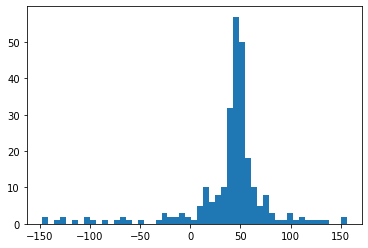

ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicWavs: Finished playing.
ReadMicW

In [45]:
#Noise score
plt.hist([c[0] for c in res if len(c) > 0], bins=51)